# Imports

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import sys


import xobjects as xo
import xtrack as xt
import xpart as xp

sys.path.append('../')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp

LINEFOLDER   = '../Data/Lines/'
SURVEYFOLDER = '../Data/Surveys/'
df_columns = ['name', 's', 'x', 'px', 'y', 'py', 'zeta', 'delta', 'ptau', 'betx', 'bety', 'alfx', 'alfy', 'gamx', 'gamy', 'dx', 'dpx', 'dy', 'dpy', 'mux', 'muy', 'qx', 'qy', 'qs', 'dqx', 'dqy']


line   = {}
twiss  = {}
survey = {}

# Importing survey
for seq in ['lhcb1','lhcb2']:
    _beam = seq[-2:]
    survey[_beam] = pd.read_pickle(SURVEYFOLDER + f'survey_opticsfile32_{seq}.pkl')

# Importing twiss
for seq in ['lhcb1','lhcb4']:
    _beam = seq[-2:]
    
    # Importing Line
    line[_beam] = xPlus.importLine(LINEFOLDER + f'line_opticsfile32_{seq}.json')
    
    # Importing twiss and tracker
    if _beam == 'b1':
        tracker = xt.Tracker(line=line[_beam])
        xtwiss  = tracker.twiss()
    else:
        xtwiss  = xt.Tracker(line=line[_beam]).twiss()
    
    twiss[_beam]= pd.DataFrame(xtwiss,columns = df_columns)
    twiss[_beam].set_index('name',inplace=True)


# Creating twiss b2 from b4
#==========================================
twiss['b2'] = twiss['b4'].copy()

# Flipping x
twiss['b2']['x']   = -twiss['b2']['x']
twiss['b2']['px']  = -twiss['b2']['px']
twiss['b2']['dpx'] = -twiss['b2']['dpx']

# Flipping s
lhcb2_L     = twiss['b2'].loc['_end_point','s']
twiss['b2']['s'] = (-twiss['b2']['s']+lhcb2_L).mod(lhcb2_L)
twiss['b2'].loc[['lhcb2ip3_p_','_end_point'],'s'] = lhcb2_L
twiss['b2'].sort_values(by='s',inplace=True)

# Changing _den to _dex
newIdx = twiss['b2'].index.str.replace('_dex','_tmp_dex')
newIdx = newIdx.str.replace('_den','_dex')
newIdx = newIdx.str.replace('_tmp_dex','_den')
twiss['b2'].index = newIdx
#==========================================

# Filtering twiss
#====================================
for ridof in ['drift','..']:
    for beam in ['b1','b2']:
        twiss[beam]    =    twiss[beam][np.invert(twiss[beam].index.str.contains(ridof,regex=False))]

for beam in ['b2']:
        ridof = 'bbcw'
        twiss[beam]    =    twiss[beam][np.invert(twiss[beam].index.str.contains(ridof,regex=False))]
#====================================

# Clearing xsuite ouput
clear_output(wait=False)






# Creating IP objects!

In [2]:
B1 = inp.Beam('b1',twiss['b1'],survey['b1'],
              Nb       = 1.15e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)
    
B2 = inp.Beam('b2',twiss['b2'],survey['b2'],
              Nb       = 1.15e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)

IP1 = inp.InteractionPoint('ip1',B1,B2)
IP5 = inp.InteractionPoint('ip5',B1,B2)

--- 

# Testing Survey:

generating ./b982e36dd6054019b68edf570fd12609.c
the current directory is '/home/phbelang/abp/BBStudies/Tests'
running build_ext
building 'b982e36dd6054019b68edf570fd12609' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c b982e36dd6054019b68edf570fd12609.c -o ./b982e36dd6054019b68edf570fd12609.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/minic

generating ./8c5747a3d48a4c39ae05517752eff88c.c
the current directory is '/home/phbelang/abp/BBStudies/Tests'
running build_ext
building '8c5747a3d48a4c39ae05517752eff88c' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c 8c5747a3d48a4c39ae05517752eff88c.c -o ./8c5747a3d48a4c39ae05517752eff88c.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/minic

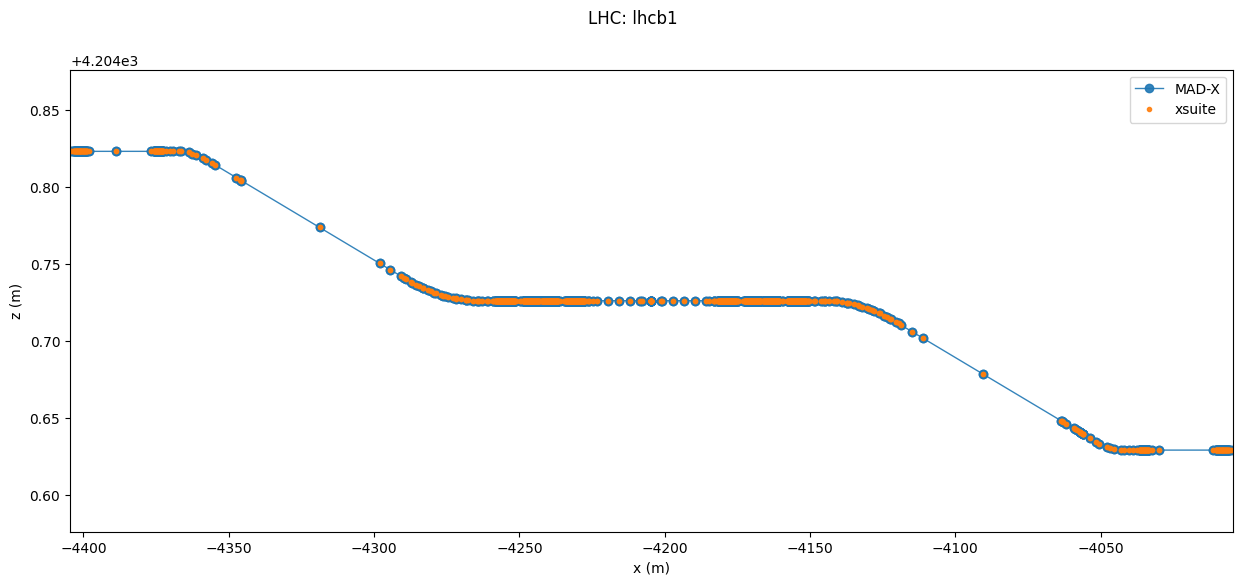

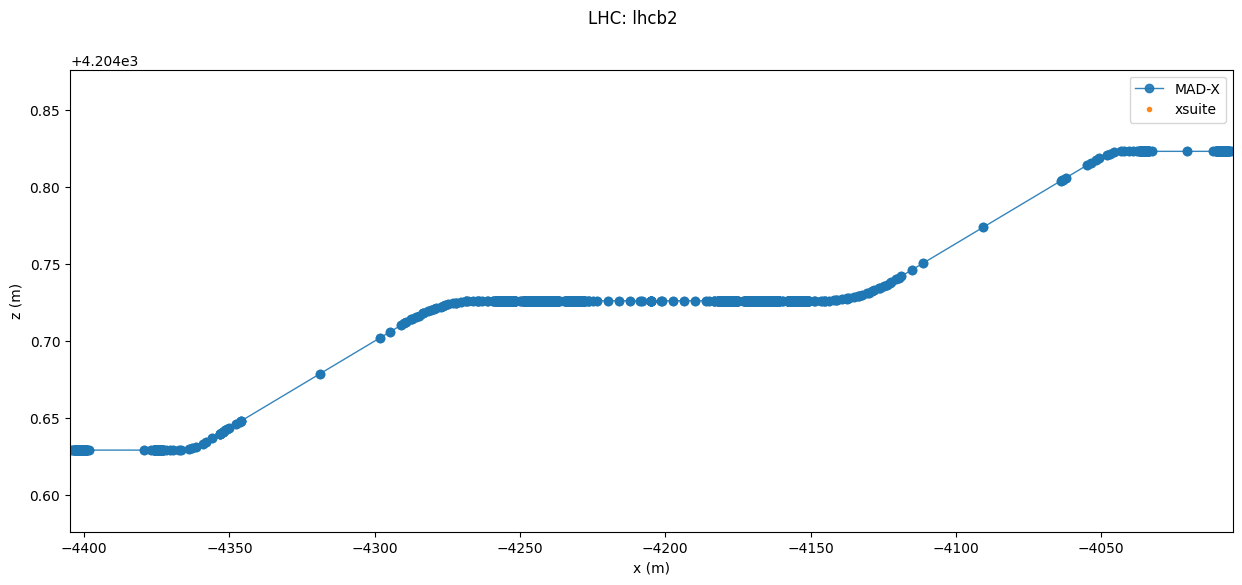

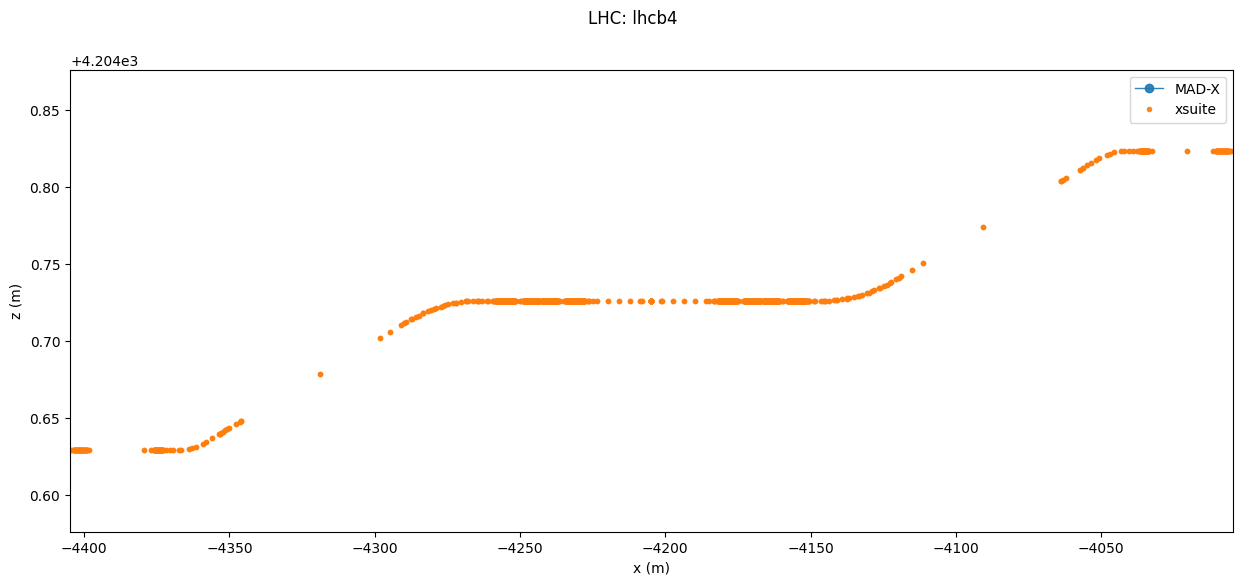

In [8]:
for seq in ['lhcb1','lhcb2','lhcb4']:
    _beam = seq[-2:]

    if _beam in survey.keys():
        srvmad = survey[_beam]
    else:
        srvmad = pd.DataFrame({'s':[np.nan],'z':[np.nan],'x':[np.nan]})

    if _beam in line.keys():
        if _beam == 'b4':
            srvXsuite  = xt.Tracker(line=line[_beam]).survey(theta0=np.pi).to_pandas(index='name')
        else:
            srvXsuite  = xt.Tracker(line=line[_beam]).survey().to_pandas(index='name')
    else:
        srvXsuite = pd.DataFrame({'s':[np.nan],'Z':[np.nan],'X':[np.nan]})



    plt.figure(figsize=(15,6))
    plt.suptitle(f'LHC: {seq}')
    plt.plot(srvmad['x']   ,srvmad['z']   ,'-o',color='C0',alpha=0.9,label='MAD-X' ,lw=1)
    plt.plot(srvXsuite['X'],srvXsuite['Z'],'.',color='C1',alpha=0.9,label='xsuite')
    
    plt.legend()
    #plt.axis('square')
    _IP = 'ip5'
    try:
        plt.xlim([srvmad.loc[_IP,'x']-200,srvmad.loc[_IP,'x']+200])
        plt.ylim([srvmad.loc[_IP,'z']-150e-3,srvmad.loc[_IP,'z']+150e-3])
    except:
        plt.xlim([srvXsuite.loc[_IP,'X']-200,srvXsuite.loc[_IP,'X']+200])
        plt.ylim([srvXsuite.loc[_IP,'Z']-150e-3,srvXsuite.loc[_IP,'Z']+150e-3])
    plt.xlabel('x (m)')
    plt.ylabel(r'z (m)')

In [10]:
survey['b2']

,name,keyword,s,l,angle,x,y,z,theta,phi,psi,globaltilt,tilt,slot_id,assembly_id,mech_sep,v_pos,comments
ip3,ip3:1,marker,0.0000,0.0000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,
drift_0[0],drift_0:0,drift,18.7000,18.7000,0.0,0.00000,0.0,18.700000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,
mcbwh.4r3.b2,mcbwh.4r3.b2:1,hkicker,18.7000,0.0000,0.0,0.00000,0.0,18.700000,0.000000,0.0,0.0,0.0,0.0,134547.0,0.0,0.224,0.0,
drift_1[0],drift_1:0,drift,22.4445,3.7445,0.0,0.00000,0.0,22.444500,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,
bpmw.4r3.b2,bpmw.4r3.b2:1,monitor,22.4445,0.0000,0.0,0.00000,0.0,22.444500,0.000000,0.0,0.0,0.0,0.0,182513.0,0.0,0.224,0.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bpmw.4l3.b2,bpmw.4l3.b2:1,monitor,26636.3627,0.0000,0.0,-0.00008,0.0,-22.520622,-6.283185,0.0,0.0,0.0,0.0,297861.0,0.0,0.224,0.0,
drift_30870[0],drift_30870:0,drift,26637.8532,1.4905,0.0,-0.00008,0.0,-21.030122,-6.283185,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,
mcbwv.4l3.b2,mcbwv.4l3.b2:1,vkicker,26637.8532,0.0000,0.0,-0.00008,0.0,-21.030122,-6.283185,0.0,0.0,0.0,0.0,297860.0,0.0,0.224,0.0,
drift_30871[0],drift_30871:0,drift,26658.8832,21.0300,0.0,-0.00008,0.0,-0.000122,-6.283185,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,


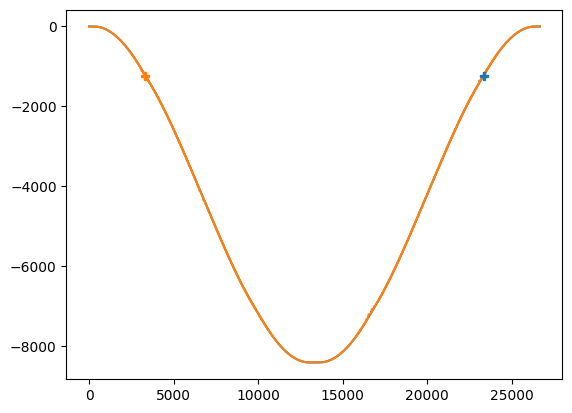

In [14]:
plt.figure()
plt.plot(survey['b2'].s,survey['b2'].x)
plt.plot(srvXsuite.s,srvXsuite.X)
for _IP in ['ip2']:
    plt.plot(survey['b2'].loc[_IP,'s'],survey['b2'].loc[_IP,'x'],'P',color='C0')
    plt.plot(srvXsuite.loc[_IP,'s'],srvXsuite.loc[_IP,'X'],'P',color='C1')

generating ./9ae4a5984f6b4bf887174a87fb0e61c9.c
the current directory is '/home/phbelang/abp/BBStudies/Tests'
running build_ext
building '9ae4a5984f6b4bf887174a87fb0e61c9' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c 9ae4a5984f6b4bf887174a87fb0e61c9.c -o ./9ae4a5984f6b4bf887174a87fb0e61c9.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/minic

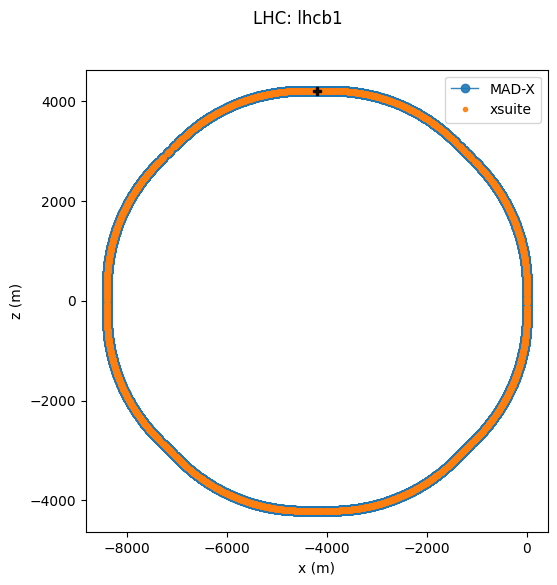

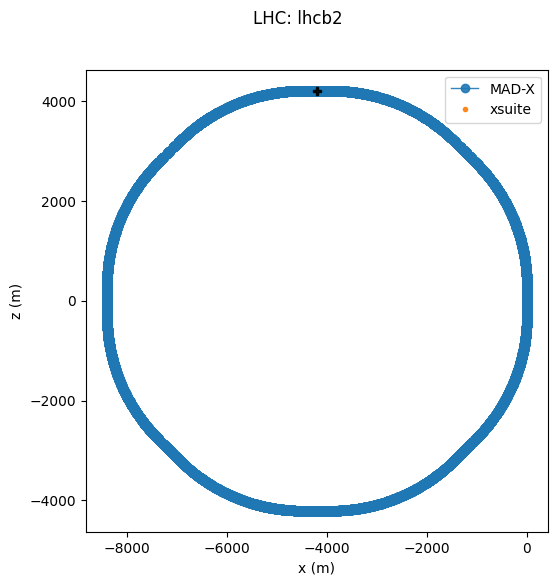

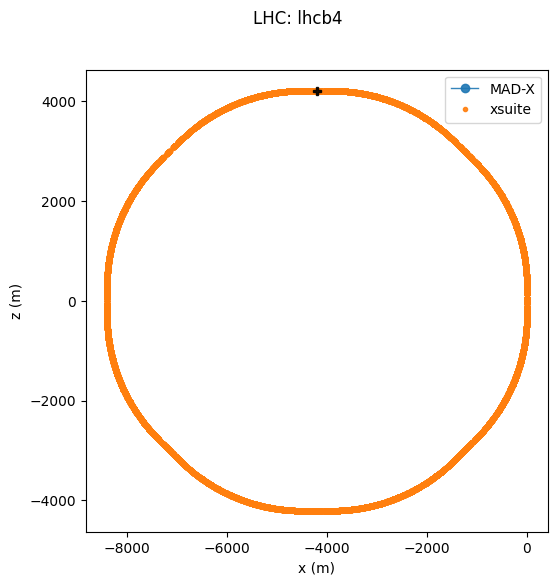

In [7]:
for seq in ['lhcb1','lhcb2','lhcb4']:
    _beam = seq[-2:]

    if _beam in survey.keys():
        srvmad = survey[_beam]
    else:
        srvmad = pd.DataFrame({'s':[np.nan],'z':[np.nan],'x':[np.nan]})

    if _beam in line.keys():
        if _beam == 'b4':
            srvXsuite  = xt.Tracker(line=line[_beam]).survey(theta0=np.pi).to_pandas(index='name')
        else:
            srvXsuite  = xt.Tracker(line=line[_beam]).survey().to_pandas(index='name')
    else:
        srvXsuite = pd.DataFrame({'s':[np.nan],'Z':[np.nan],'X':[np.nan]})



    plt.figure(figsize=(15,6))
    plt.suptitle(f'LHC: {seq}')
    plt.plot(srvmad['x']   ,srvmad['z']   ,'-o',color='C0',alpha=0.9,label='MAD-X' ,lw=1)
    plt.plot(srvXsuite['X'],srvXsuite['Z'],'.',color='C1',alpha=0.9,label='xsuite')
    
    plt.legend()
    #plt.axis('square')
    _IP = 'ip5'
    try:
        plt.plot(srvmad.loc[_IP,'x']   ,srvmad.loc[_IP,'z']   ,'P',color='k',alpha=0.9,label=_IP)
    except:
        plt.plot(srvXsuite.loc[_IP,'X'],srvXsuite.loc[_IP,'Z'],'P',color='k',alpha=0.9,label=_IP)
    plt.axis('square')
    plt.xlabel('x (m)')
    plt.ylabel(r'z (m)')

# General IP plot

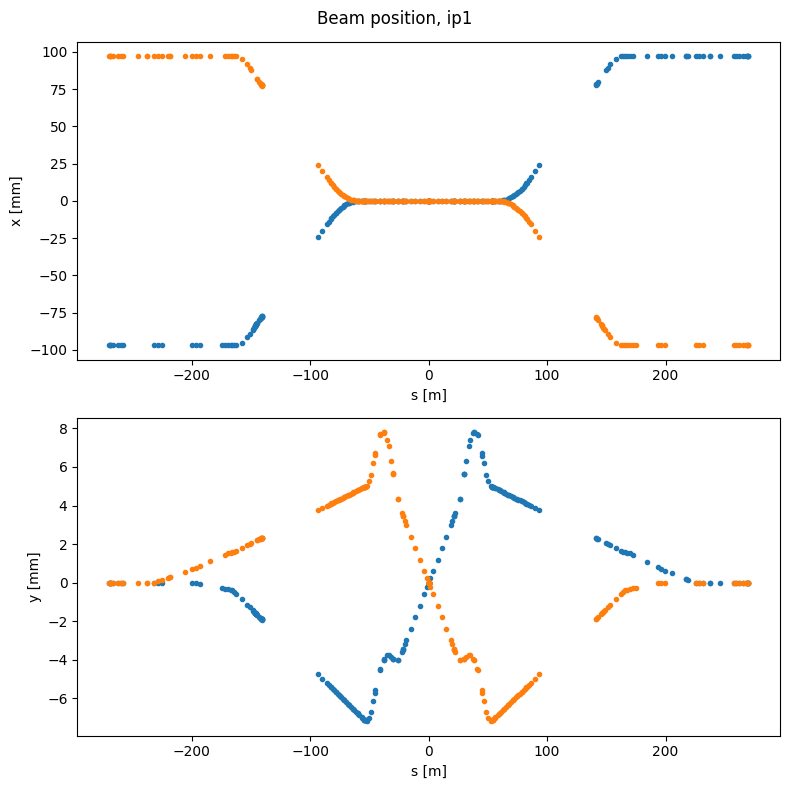

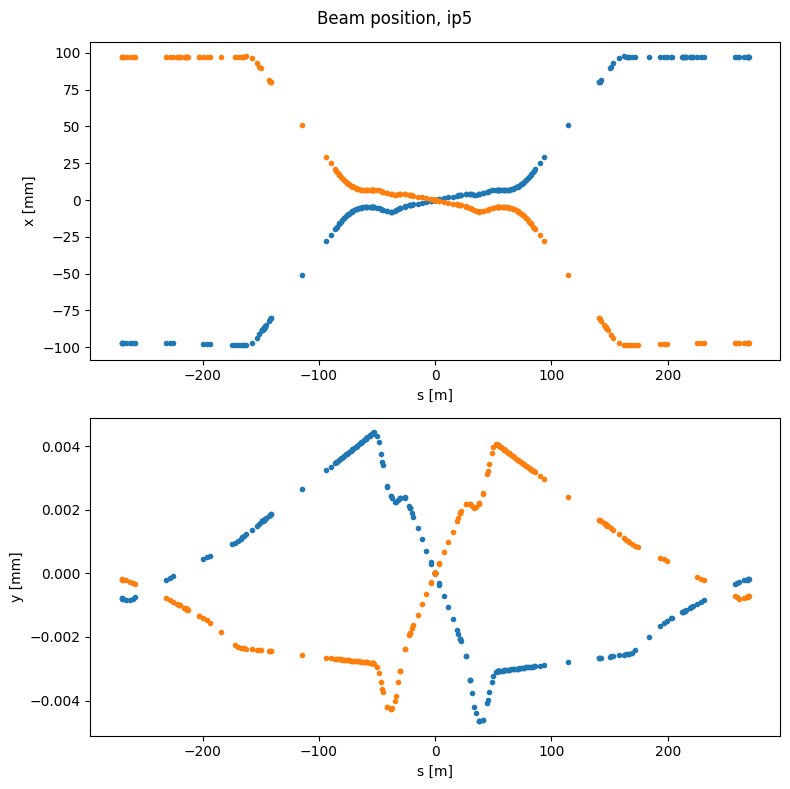

In [3]:
chosenIPs = ['ip1','ip5']
for _IP in chosenIPs:

    # ROI around IP
    ROI_twiss_b1,ROI_survey_b1 = inp.extract_IP_ROI(_IP,'b1',twiss['b1'],survey['b1'])
    ROI_twiss_b2,ROI_survey_b2 = inp.extract_IP_ROI(_IP,'b2',twiss['b2'],survey['b2'])

  
    # Plotting
    
    fig, axes = plt.subplots(2, 1,figsize=(8,8))
    fig.suptitle(f'Beam position, {_IP}')
    for plane,ax in zip(['x','y'],axes.flatten()):
        
        center = ROI_twiss_b1.loc[_IP,f'{plane}_lab']
        ax.plot(ROI_twiss_b1['s_lab'],(ROI_twiss_b1[f'{plane}_lab']-center)/1e-3,'.')
        ax.plot(ROI_twiss_b2['s_lab'],(ROI_twiss_b2[f'{plane}_lab']-center)/1e-3,'.')
        
            
    
        ax.set(xlabel='s [m]', ylabel=f'{plane} [mm]')
        
    plt.tight_layout()

# Using the IP objects

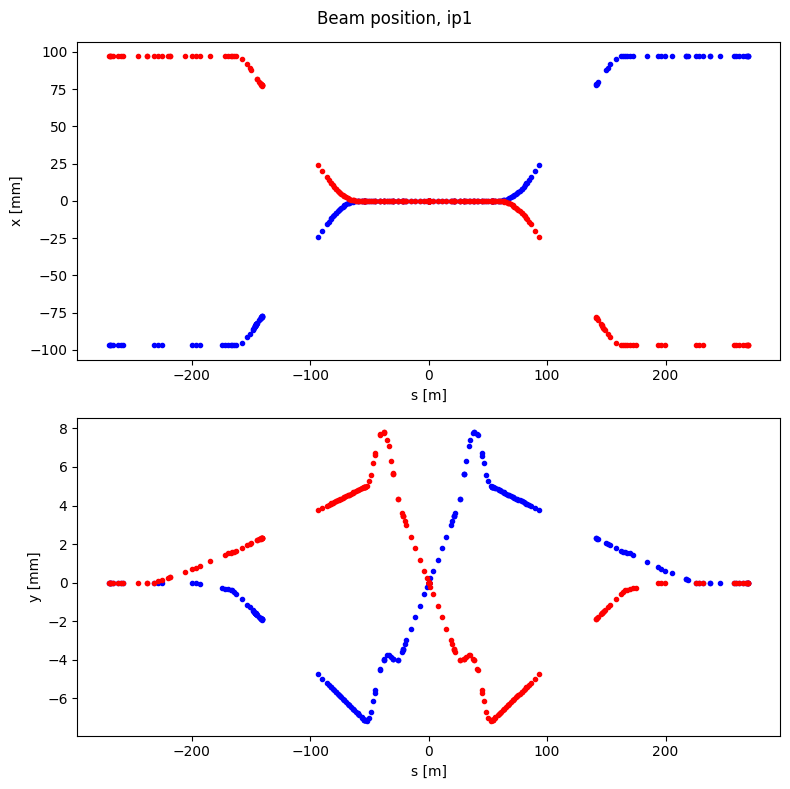

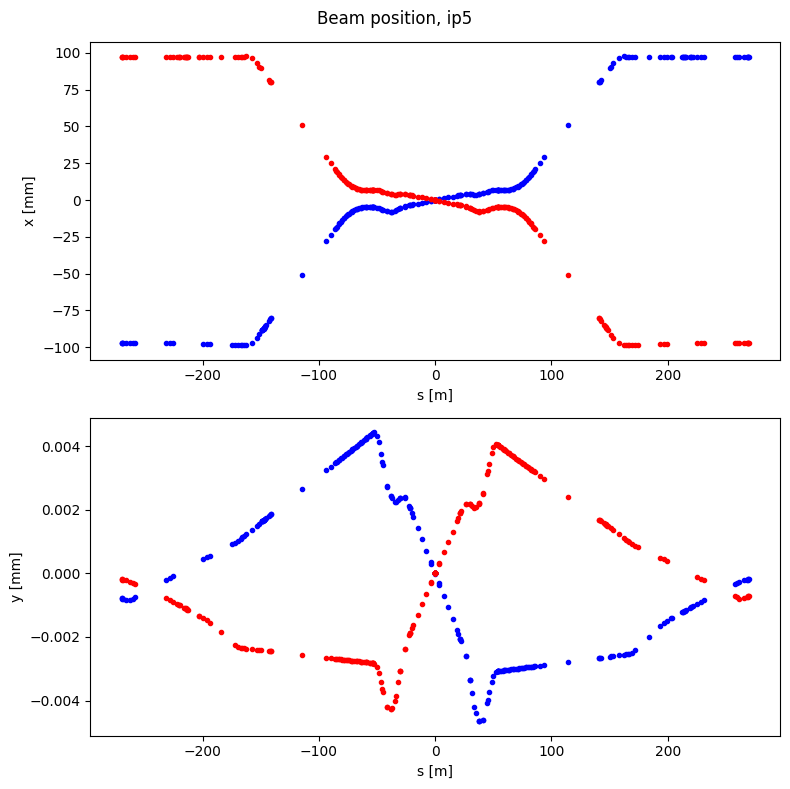

In [4]:
chosenIPs = ['ip1','ip5']
for _IP in [IP1,IP5]:

  
    # Plotting
    
    fig, axes = plt.subplots(2, 1,figsize=(8,8))
    fig.suptitle(f'Beam position, {_IP.name}')
    for plane,ax in zip(['x','y'],axes.flatten()):
        center = _IP.b1.twiss.loc[_IP.name,f'{plane}_lab']
        ax.plot(_IP.b1.twiss['s_lab'],(_IP.b1.twiss[f'{plane}_lab']-center)/1e-3,'.b')
        ax.plot(_IP.b2.twiss['s_lab'],(_IP.b2.twiss[f'{plane}_lab']-center)/1e-3,'.r')
        
            
    
        ax.set(xlabel='s [m]', ylabel=f'{plane} [mm]')
        
    plt.tight_layout()

# Beam-beam separation

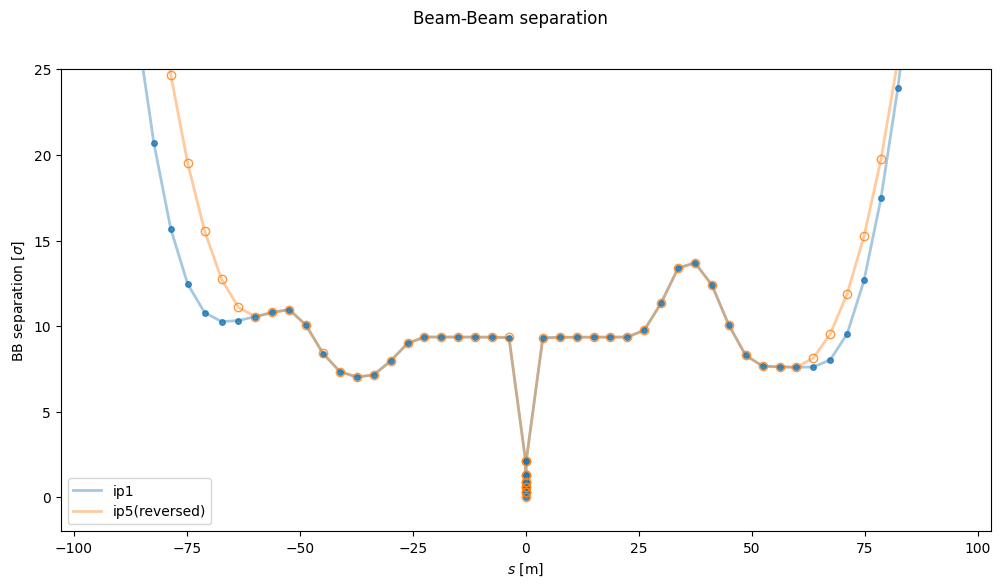

In [5]:
fig = plt.figure(figsize=(12,6))
fig.suptitle(f'Beam-Beam separation')

for _IP in [IP1,IP5]:
    
    # Plotting   
   
    dx_n_tot = np.sqrt(_IP.bb['dx_n']**2 + _IP.bb['dy_n']**2)
    if _IP.name == 'ip1':
        plt.plot(_IP.bb['s'],dx_n_tot,'-',color='C0',alpha=0.4,lw=2,label=_IP.name,zorder=-10)
        plt.plot(_IP.bb['s'],dx_n_tot,ls='' ,color='C0',alpha=0.8,marker='.',ms=8)
    else:
        plt.plot(-_IP.bb['s'],dx_n_tot,'-',color='C1',alpha=0.4,lw=2,label=_IP.name + '(reversed)',zorder=-9)
        plt.plot(-_IP.bb['s'],dx_n_tot,ls='' ,color='C1',alpha=0.8,marker='.',mfc='none',ms=12)
    plt.legend()
    
    plt.xlabel(r'$s$ [m]')
    plt.ylabel(r'BB separation [$\sigma$]')
    
    plt.ylim([-2,25])